## Classificador ternário para características morfométricas de núcleo/citoplasma de células cervicais 

Classificador: Normal vs ASC-US, LSIL vs ASC-H, HSIL, Carc

In [1]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import feature_selection as fs

from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb
import utils.shapeFeatures, utils.functions
import csv

In [2]:
IMG_W = 1376
IMG_H = 1020
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'LSIL':2, 'ASC-H':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'LSIL', 3:'ASC-H', 4: 'HSIL', 5:'Invasive Carcinoma'} 
PATH_masks = os.path.join(os.getcwd(), 'mascaras')  
dataset_file_nuclei = os.path.join(os.getcwd(), 'base', 'nucleus-segmentations.csv') 
dataset_file_cytoplasm = os.path.join(os.getcwd(), 'base', 'cytoplasm-segmentations.csv') 

In [3]:
#print(dataset_file_nuclei, dataset_file_cytoplasm)

### Funções para extração de features - shape e contorno:

##### Leitura da base: segmentação manual para nucleo (N) e citoplasma (C)


In [4]:
#df_nucleos, df_cyto,df_nucleos_full, df_cyto_full = utils.shapeFeatures.list_cells(dataset_file_nuclei, dataset_file_cytoplasm) 
#df_cyto_full
#count_cells, df = utils.shapeFeatures.make_masks_DF(df_nucleos, df_cyto, df_nucleos_full, df_cyto_full)
#df
#count_cells, np.sum(count_cells)

#df = df.astype('float64')
#df.to_pickle('dataCRIC2.csv')

In [5]:
df2 = pd.DataFrame()
df2 = pd.read_pickle('dataCRIC2.csv')
image_id = 1
cell_id = 14796
(xN, yN, xC, yC) = utils.shapeFeatures.get_contour_cell_points(df2, image_id, cell_id)
#utils.shapeFeatures.show_points(df2, image_id, cell_id)


In [6]:
# --- Calc curvatures
x = xN
y = yN
sigma = (np.real(x.shape[0])) * 0.03
x_smooth, gaus_f = utils.shapeFeatures.gaus_smooth_signal(x, sigma)
y_smooth, gaus_f = utils.shapeFeatures.gaus_smooth_signal(y, sigma)

#--- 
#x2_smooth, gaus_f = utils.shapeFeatures.gaus_smooth_signal (x, 12)
#y2_smooth, gaus_f = utils.shapeFeatures.gaus_smooth_signal(y, 12)


# Calcula x'(t),x''(t), y'(t), y''(t), a partir das transformadas:
fft_x, freqs = utils.shapeFeatures.fft_freqs(x_smooth)
energy_x = utils.shapeFeatures.total_energy(fft_x)
dx, dx2 = utils.shapeFeatures.derivatives(fft_x, freqs)

fft_y, freqs = utils.shapeFeatures.fft_freqs(y_smooth)
energy_y = utils.shapeFeatures.total_energy(fft_y)
dy, dy2 = utils.shapeFeatures.derivatives(fft_y, freqs)

curvs = utils.shapeFeatures.curvatures(dx, dx2, dy, dy2)
m_curvs = np.abs(curvs)
fft_curvs, freqs = utils.shapeFeatures.fft_freqs(m_curvs)
dK, d2K = utils.shapeFeatures.derivatives(fft_curvs, freqs)
zero_cross, max_points_mcurv = utils.shapeFeatures.calc_max_points(dK, d2K)

x.shape[0], x.shape[0] *0.1, sigma,


(122, 12.200000000000001, 3.6599999999999997)

In [7]:
def shift_points(x, y):
    minx = np.min(x)
    miny = np.min(y)
    x_shift = x.copy()
    x_shift= (x - minx) + 10
    y_shift = y.copy()
    y_shift = (y - miny) + 10
    return x_shift, y_shift


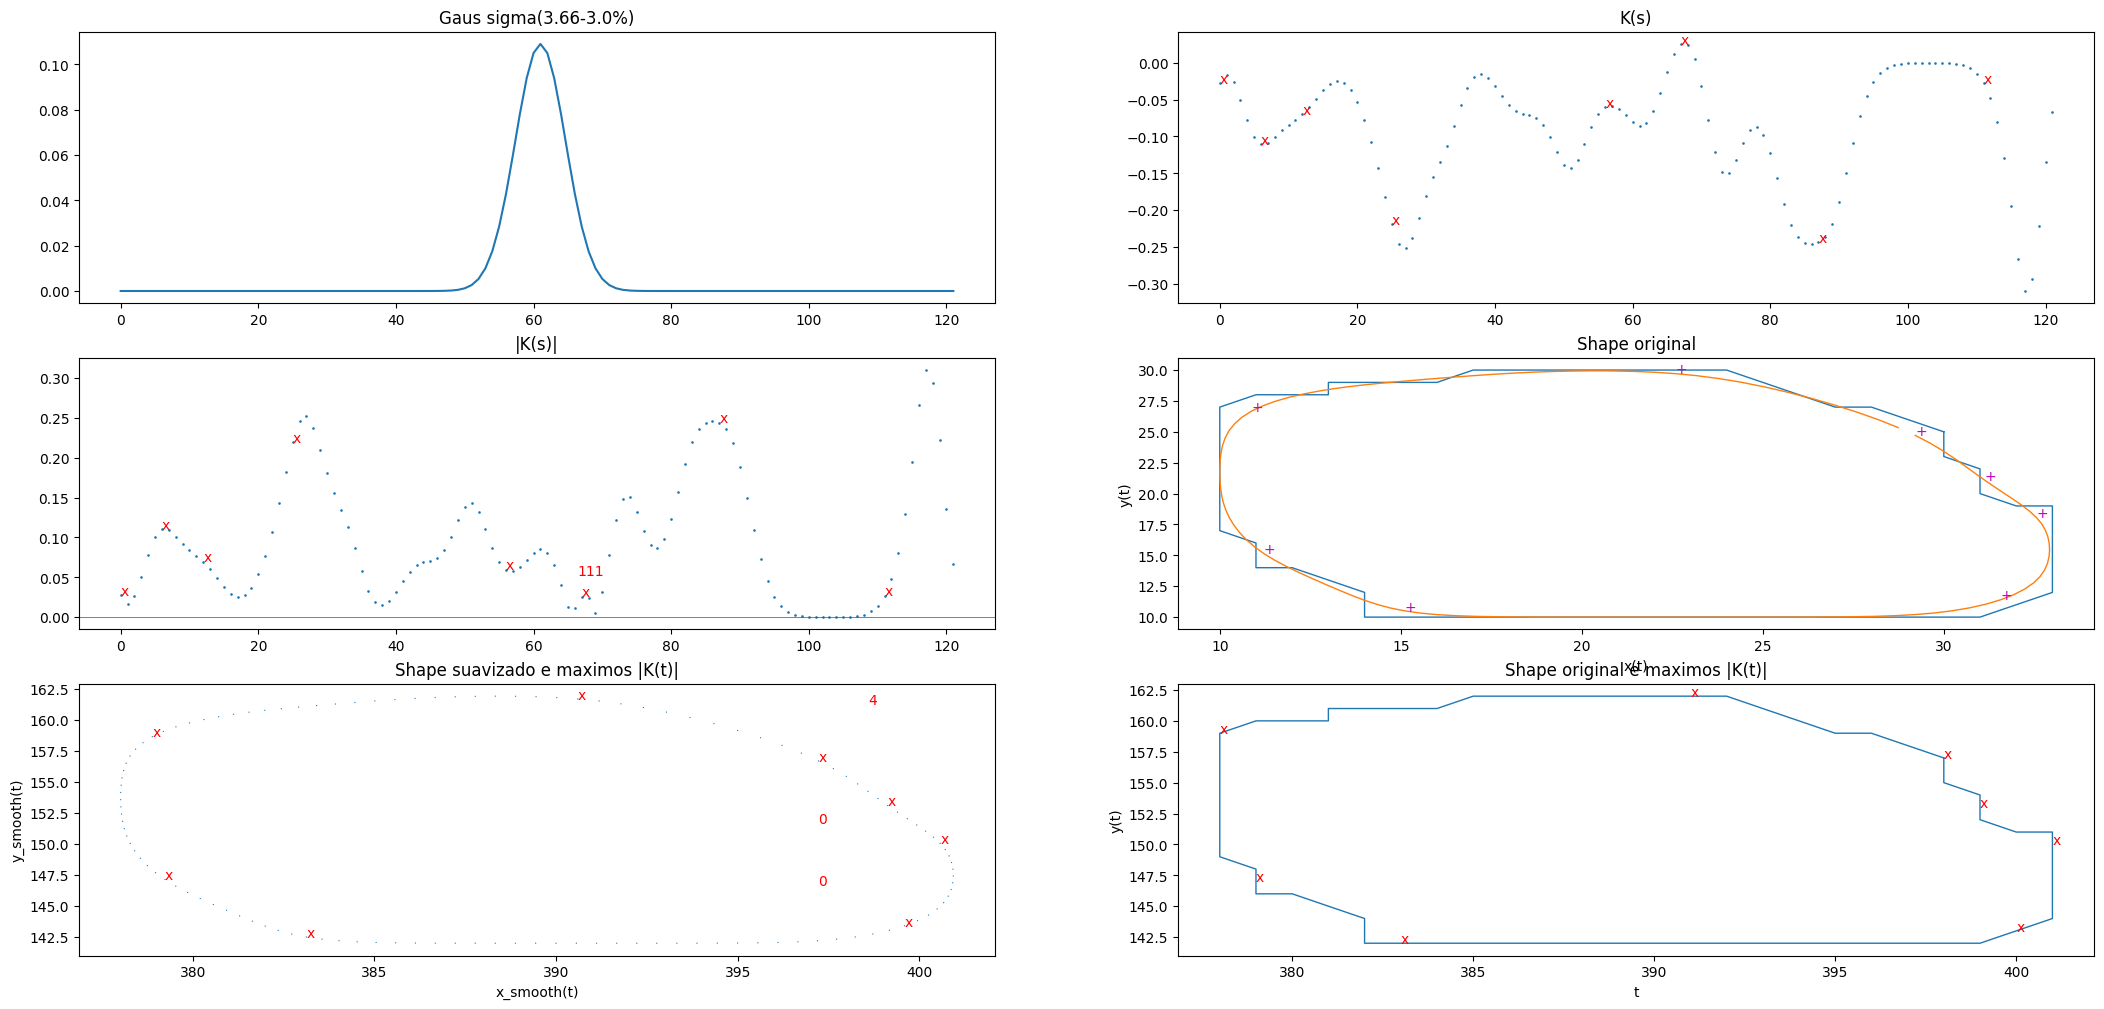

In [10]:
n = x.shape[-1]
t = np.arange(n)

# get the first element of max_points_mcurv
first = max_points_mcurv.pop()  #remove from head of queue
max_points_mcurv.append(first)  #insert from head of queue
last = max_points_mcurv.popleft()  #remove from head of queue
max_points_mcurv.appendleft(last)  #insert from head of queue

fig,axis = plt.subplots(3, 2, figsize=(26,12))
axis[0,0].plot(t, gaus_f)
axis[0,0].set( title = 'Gaus sigma({:.2f}-{:.1%})'.format(sigma, sigma/n))

axis[0,1].scatter(t, curvs,  s=0.8, linewidth=1.0) #, edgecolors = 'none')
axis[0,1].set( title = 'K(s)') 
for t2 in max_points_mcurv:
    axis[0,1].text(t2, curvs[t2], 'x', color='r') 

axis[1,0].scatter(t, m_curvs, s=0.8, linewidth=1.0) #, edgecolors = 'none')
axis[1,0].set( title = '|K(s)|') 
axis[1,0].axhline(0,0,1, linewidth = 0.5, color='r') 
for t2 in max_points_mcurv:
    axis[1,0].text(t2, m_curvs[t2], 'x', color='r') 


# Shape após suavização:
xf, yf = shift_points(x, y)
xsf, ysf = shift_points(x_smooth, y_smooth)

axis[1,1].plot(xf, yf, xsf, ysf, linewidth=1.0)
axis[1,1].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 'x(t)', ylabel = 'y(t)', title = 'Shape original')
for t2 in max_points_mcurv:
    axis[1,1].text(xsf[t2], ysf[t2], '+', color='m') 

axis[2,0].scatter(x_smooth, y_smooth, s=0.8, linewidth=1.0 ) #, edgecolors = 'none')
axis[2,0].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 'x_smooth(t)', ylabel = 'y_smooth(t)', title = 'Shape suavizado e maximos |K(t)|')
for t2 in max_points_mcurv:
    axis[2,0].text(x_smooth[t2], y_smooth[t2], 'x', color='r') 
axis[2,0].text(x_smooth[0], y_smooth[0]-5, '0', color='r')   
axis[2,0].text(x_smooth[4], y_smooth[4]+7, '4', color='r')
axis[2,0].text(x_smooth[first], y_smooth[first]-10, first, color='r')
axis[2,0].text(x_smooth[last], y_smooth[last]+10, last, color='r')
#axis[1].axhline(0,0,1, linewidth = 0.5, color='r') 

axis[2,1].plot(x, y, linewidth=1.0) 
axis[2,1].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 't', ylabel = 'y(t)', title = 'Shape original e maximos |K(t)|')
for t2 in max_points_mcurv:
    axis[2,1].text(x[t2], y[t2], 'x', color='r') 
plt.show()

In [ ]:
''' 
axis[1,1].scatter(t, dK,linewidth=1.0)
axis[1,1].set( title = 'Kd') 
for t2 in max_points_mcurv:
    axis[1,1].text(t2, dK[t2], 'x', color='r') 
axis[1,1].axhline(0,0,1, linewidth = 0.5, color='r') 

axis[1,2].scatter(t, d2K, linewidth=1.0)
axis[1,2].set( title = 'K2d') 
for t2 in max_points_mcurv:
    axis[1,2].text(t2, d2K[t2], 'x', color='r') 
axis[1,2].axhline(0,0,1, linewidth = 0.5, color='r') 
'''



'''
n = dK.shape[-1]
t = np.arange(n)

fig, axis = plt.subplots(2, 1, figsize=(22,12), sharex=True)

axis[0].scatter(t, dK)
axis[0].set( title = 'Kd', xlim=(n-3, n+3), xticks=(np.arange(0, 128, 5))) 
for t1 in zero_cross:
    axis[0].text(t1, dK[t1], 'x', color='m') 
    axis[0].text(t1, np.real(dK[t1]-0.01), "s:{:.1f}:{:.1f}".format(np.sign(np.real(dK[t1])), \
                                     np.sign(np.real(dK[t1+1]))), color='m') 
    axis[0].axvline(t1,0,1, linewidth = 0.2, color='r') 
    axis[0].axvline(t1+1,0,1, linewidth = 0.2, color='r') 
for t2 in max_points_mcurv:
    axis[0].text(t2, dK[t2], '#', color='r') 
    axis[0].text(t2+1, np.real(dK[t2+1]+0.01), "t+1:{:.1f}".format(np.real(dK[t2+1])), color='r') 
    axis[0].axvline(t2,0,1, linewidth = 0.2, color='r') 
    axis[0].axvline(t2+1,0,1, linewidth = 0.2, color='r') 
 
axis[0].axhline(0,0,1, linewidth = 0.2, color='r') 

axis[1].scatter(t, d2K)
axis[1].set( title = 'K2d') 
for t2 in max_points_mcurv:
    axis[1].text(t2, d2K[t2], 'x', color='r') 
    axis[1].axvline(t2,0,1, linewidth = 0.2, color='r') 
axis[1].axhline(0,0,1, linewidth = 0.2, color='r') 
'''

'\nn = dK.shape[-1]\nt = np.arange(n)\n\nfig, axis = plt.subplots(2, 1, figsize=(22,12), sharex=True)\n\naxis[0].scatter(t, dK)\naxis[0].set( title = \'Kd\', xlim=(n-3, n+3), xticks=(np.arange(0, 128, 5))) \nfor t1 in zero_cross:\n    axis[0].text(t1, dK[t1], \'x\', color=\'m\') \n    axis[0].text(t1, np.real(dK[t1]-0.01), "s:{:.1f}:{:.1f}".format(np.sign(np.real(dK[t1])),                                      np.sign(np.real(dK[t1+1]))), color=\'m\') \n    axis[0].axvline(t1,0,1, linewidth = 0.2, color=\'r\') \n    axis[0].axvline(t1+1,0,1, linewidth = 0.2, color=\'r\') \nfor t2 in max_points_mcurv:\n    axis[0].text(t2, dK[t2], \'#\', color=\'r\') \n    axis[0].text(t2+1, np.real(dK[t2+1]+0.01), "t+1:{:.1f}".format(np.real(dK[t2+1])), color=\'r\') \n    axis[0].axvline(t2,0,1, linewidth = 0.2, color=\'r\') \n    axis[0].axvline(t2+1,0,1, linewidth = 0.2, color=\'r\') \n \naxis[0].axhline(0,0,1, linewidth = 0.2, color=\'r\') \n\naxis[1].scatter(t, d2K)\naxis[1].set( title = \'K2d\') \n

In [ ]:
def formatting(string_numpy):
    """formatting : Conversion of String List to List
    Args:
        string_numpy (str)
    Returns:
        l (list): list of values
    """
    list_values = str(string_numpy).split(", ")
    list_values[0] = list_values[0][2:]
    list_values[-1] = list_values[-1][:-2]
    return list_values
 